In [11]:
import MarsGT 
from MarsGT.conv import *
from MarsGT.egrn import *
from MarsGT.marsgt_model import *
from MarsGT.utils import *
import anndata as ad
from collections import Counter
import copy
import dill
from functools import partial
import json
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
from operator import itemgetter
import random
import scipy
import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import hstack, vstack, coo_matrix
import seaborn as sb
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import time
import torch
import torch.cuda as cuda
from torch import nn
from torch.autograd import Variable
import torch.distributions as D
import torch.nn.functional as F
import torch_geometric.data as Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, uniform
from torch_geometric.utils import softmax as Softmax
from torchmetrics.functional import pairwise_cosine_similarity
import warnings
from warnings import filterwarnings
import xlwt
import argparse
from tqdm import tqdm
import scanpy as sc
import sys
import io
from contextlib import contextmanager
import warnings


@contextmanager
def suppress_stdout_and_warnings():
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            yield
        finally:
            sys.stdout = old_stdout
warnings.filterwarnings('ignore')

## Case1：Mouse_retina

#### load adata（Mouse_retina_all）

In [2]:
os.chdir('Mouse_retina') # Please switch to the download path of the dataset on your own.
adata = ad.read('Mouse_retina_all.h5ad') 

#### dotplot

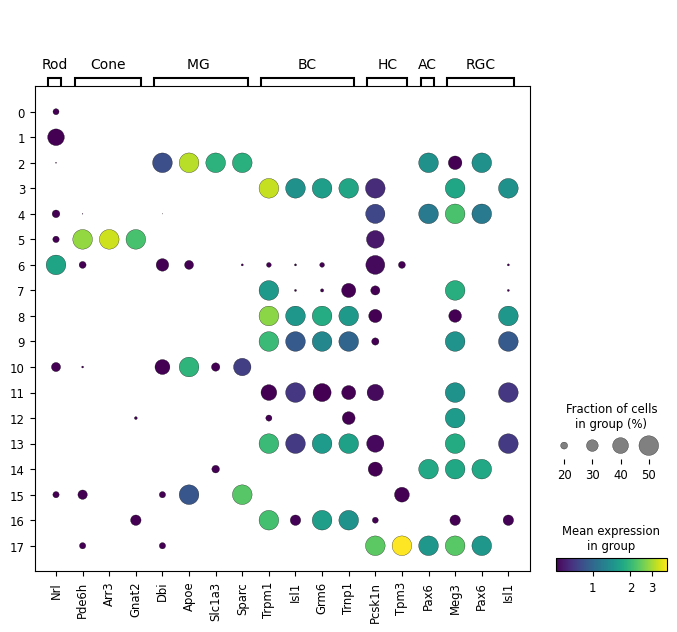

In [4]:
marker_genes_dict = {   
    "Rod": ['Nrl'],
    "Cone": ['Pde6h', 'Arr3', 'Gnat2'],
    "MG ":['Dbi','Apoe','Slc1a3','Sparc'],
    "BC":['Trpm1', 'Isl1','Grm6','Trnp1'],
    "HC":['Pcsk1n','Tpm3'],
    "AC":['Pax6'],
    "RGC":['Meg3','Pax6','Isl1']
}
sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',dot_max=0.5,dot_min=0.1,expression_cutoff=0.8,vmin=0.8,vcenter=1.1,color_map='viridis')

#### umap

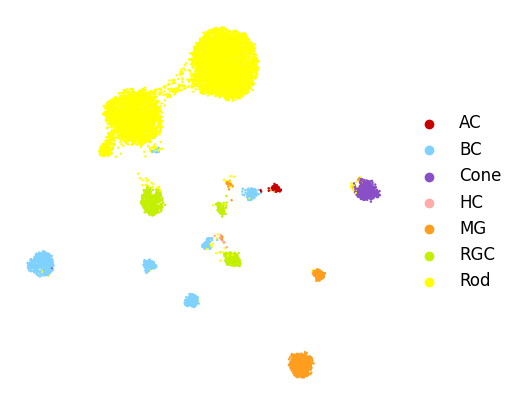

In [5]:
with plt.rc_context({'figure.figsize': (5, 5)}):   
    sc.pl.umap(adata, color= ['clu_type'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=3,frameon=False,title='')

#### heatmap

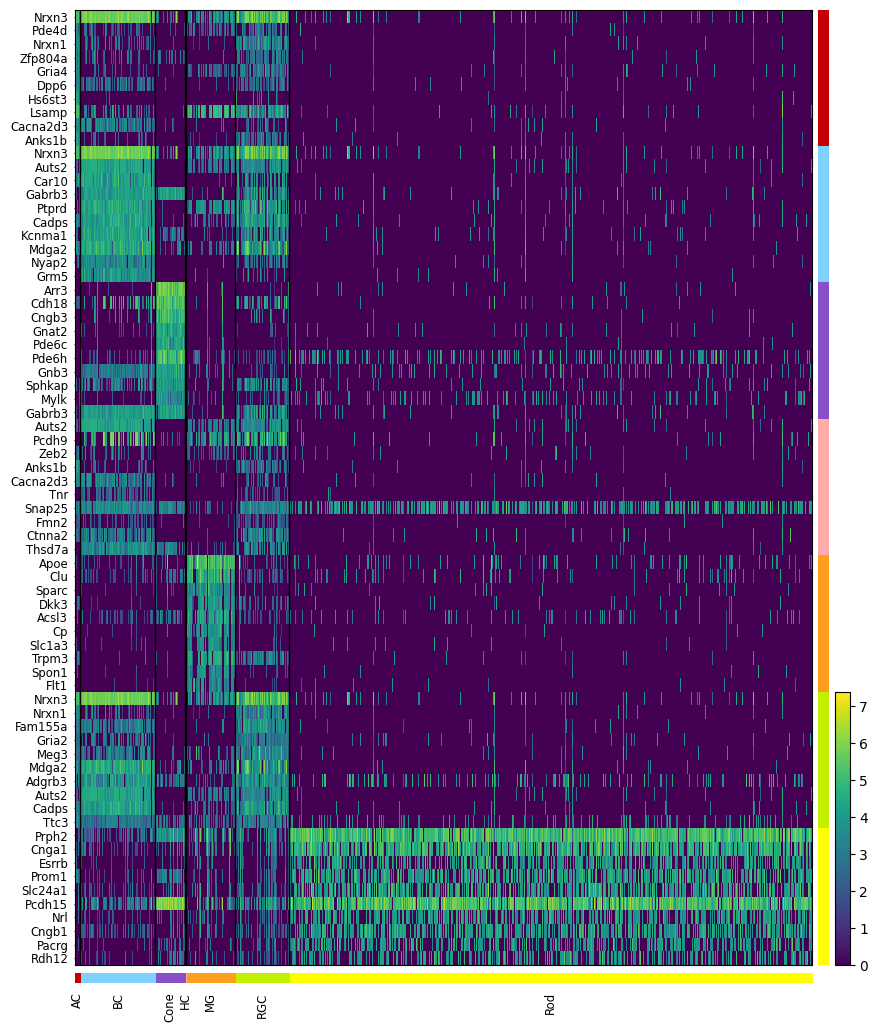

In [6]:
adata.X = adata.layers['raw']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, 'clu_type', method='t-test')
##纵排
with suppress_stdout_and_warnings():
    ax_list = sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, dendrogram=False, show=False, swap_axes=True, show_gene_labels=True)
    ax_list['groupby_ax'].set_xlabel("")

#### load adata（Mouse_retina_BC）

In [8]:
adata = ad.read('Mouse_retina_BC.h5ad')

#### dotplot

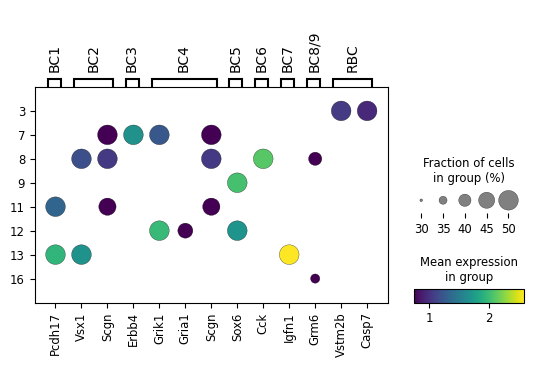

In [9]:
marker_genes_dict = {   
    "BC1": ['Pcdh17'],
    "BC2": ['Vsx1','Scgn'],
    "BC3":['Erbb4'],
    "BC4":['Grik1','Gria1','Scgn'],
    "BC5":['Sox6'],
    "BC6":['Cck'],
    "BC7":['Igfn1'],
    "BC8/9":['Grm6'],
    "RBC":['Vstm2b','Casp7']
}

sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',dot_max=0.5,dot_min=0.285,color_map='viridis',expression_cutoff=0.95,vmin=0.8,vcenter=1.5)

#### umap

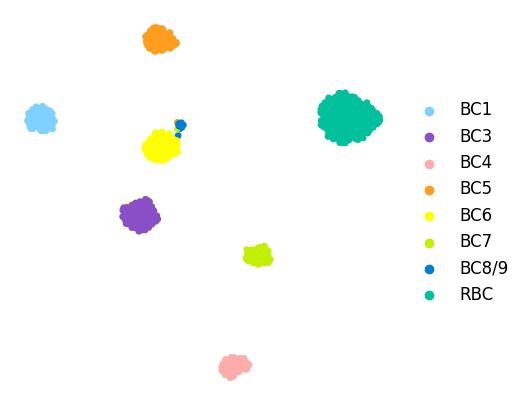

In [10]:
with plt.rc_context({'figure.figsize': (5, 5)}):    
    sc.pl.umap(adata, color= ['clu_type'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=2,frameon=False,title='')

#### heatmap

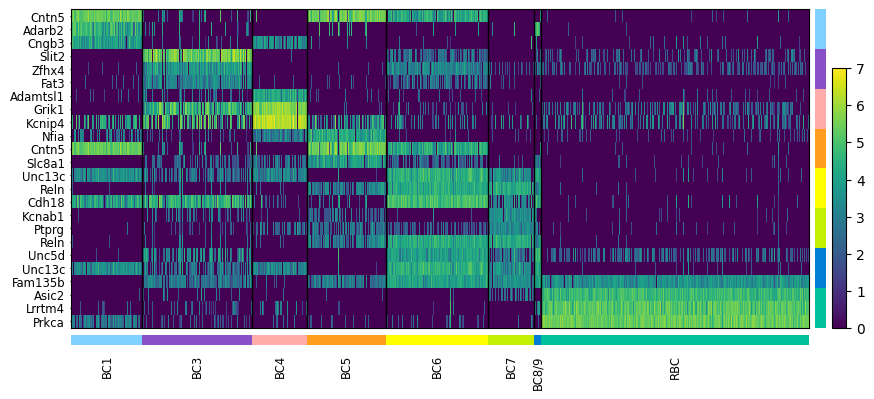

In [11]:
heat_adata =  ad.AnnData(adata.layers["raw"], dtype='int32')
heat_adata.var_names=adata.var_names
heat_adata.obs['clu_type'] = list(adata.obs['clu_type'])
heat_adata.obs['clu_type'] = heat_adata.obs['clu_type'].astype("category")
heat_adata.uns['clu_type_colors'] = [ "#7FD2FF", "#894FC6", "#FFACAA", "#FF9D1E", '#FFFF00',"#C3EF00", "#007ED3","#00C19B"]
sc.pp.normalize_total(heat_adata, target_sum=1e4)
sc.pp.log1p(heat_adata)
sc.tl.rank_genes_groups(heat_adata, 'clu_type', method='t-test')

with suppress_stdout_and_warnings():
    ax_list = sc.pl.rank_genes_groups_heatmap(heat_adata,n_genes=3,dendrogram=False,show=False,swap_axes=True)
    ax_list['groupby_ax'].set_xlabel("") 

#### EGRN

In [12]:
Total_socre_df = pd.read_csv('Total_socre_df.csv',index_col=0)# Please replace the actual path with the path to "Mouse_retina" file.
Total_socre_df

,gene,peak,score,class
343624516,Ttf1,chr2:29194127-29196308,2.414369e+01,0
343624515,Ttf1,chr2:29191479-29193244,7.943105e+00,0
248060631,Prph2,chr17:46908034-46935184,7.185151e+00,0
60926177,Cfap77,chr2:29194127-29196308,2.966689e+00,0
295565027,Slc6a6,chr6:91682646-91699915,1.452507e+00,0
...,...,...,...,...
208687543,Nmnat2,chr1:153101431-153101944,1.510207e-07,17
101765944,Erich6,chr3:58784394-58784843,1.426368e-07,17
181492584,Lyve1,chr7:111010038-111010729,1.424491e-07,17
56505914,Cdk18,chr1:132287393-132289156,1.314530e-07,17


## Case2：B_lymphoma

#### load adata（B_lymphoma_all）

In [13]:
os.chdir('B_lymphoma') # Please switch to the download path of the dataset on your own.
adata = ad.read('B_lymphoma_all.h5ad')

#### dotplot

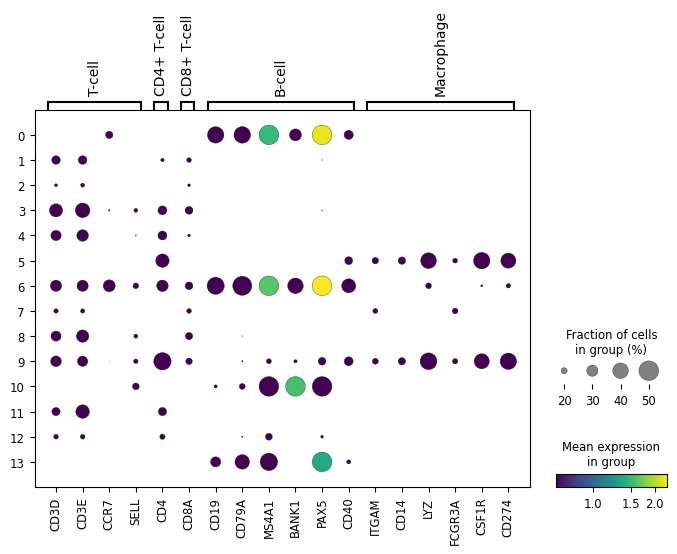

In [14]:
marker_genes_dict = {'T-cell':['CD3D', 'CD3E','CCR7','SELL'],
                     'CD4+ T-cell':['CD4'],
                     'CD8+ T-cell':['CD8A'],
                    'B-cell':['CD19', 'CD79A', 'MS4A1','BANK1','PAX5','CD40'],
                    'Macrophage':['ITGAM','CD14','LYZ','FCGR3A','CSF1R','CD274']
                    }
## dotplot
sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',color_map='viridis',dot_max=0.5,dot_min=0.12,vmin=0.8,vcenter=1.1)

#### umap

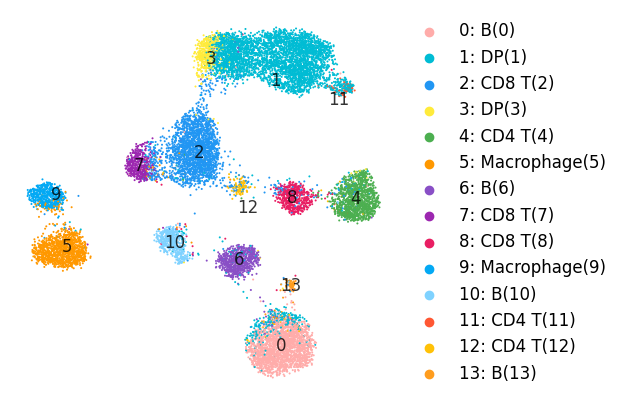

In [15]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    fig, ax = plt.subplots()
    sc.pl.umap(adata, color=['pred_type_name'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=5, frameon=False, title='',
               use_raw=False, color_map=None, ax=ax, show=False)
    
    # Add labels to the UMAP plot
    for category in adata.obs['pred_type_name'].cat.categories:
        coords = adata.obsm['X_umap'][adata.obs['pred_type_name'] == category]
        center = coords.mean(axis=0)
        ax.text(center[0], center[1], category.split(':')[0], fontsize=12,
                ha='center', va='center', color='black', alpha=0.8)
    plt.show()

#### load adata（B_lymphoma_B）

In [16]:
adata = ad.read('B_lymphoma_B.h5ad')

#### dotplot

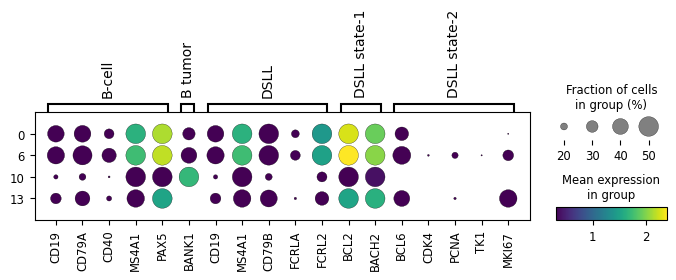

In [17]:
marker_genes_dict = {'B-cell':['CD19', 'CD79A','CD40','MS4A1','PAX5'],
                     'B tumor':['BANK1'],
                     'DSLL':['CD19','MS4A1','CD79B','FCRLA','FCRL2'],
                     'DSLL state-1':['BCL2','BACH2'],
                     'DSLL state-2':['BCL6','CDK4','PCNA','TK1','MKI67']
                     }

sc.pl.dotplot(adata,marker_genes_dict,groupby='pred_type',color_map='viridis',dot_max=0.5,dot_min=0.1,vmin=0.8,vcenter=1.1)

#### umap

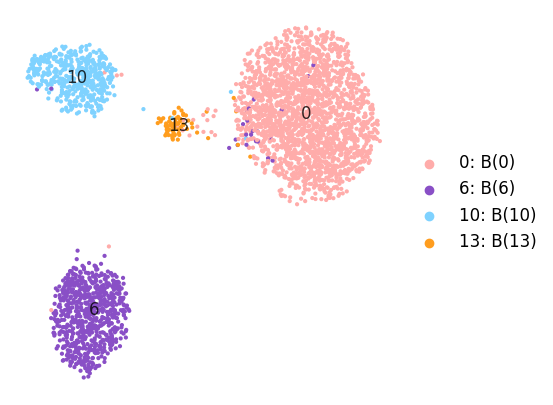

In [18]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    fig, ax = plt.subplots()
    sc.pl.umap(adata, color=['pred_type_name'], add_outline=False,
               legend_fontsize=12, legend_fontoutline=5, frameon=False, title='',
               use_raw=False, color_map=None, ax=ax, show=False)
    
    # Add labels to the UMAP plot
    for category in adata.obs['pred_type_name'].cat.categories:
        coords = adata.obsm['X_umap'][adata.obs['pred_type_name'] == category]
        center = coords.mean(axis=0)
        ax.text(center[0], center[1], category.split(':')[0], fontsize=12,
                ha='center', va='center', color='black', alpha=0.8)
    plt.show()

#### stacked_violin

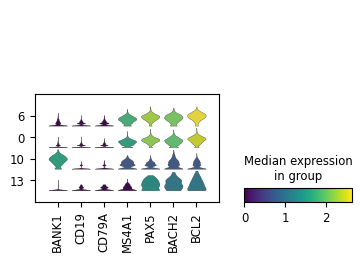

In [36]:
markers = ['BANK1','CD19','CD79A','MS4A1','PAX5','BACH2','BCL2']
sc.pl.stacked_violin(adata, markers, groupby='pred_type', cmap='viridis', rotation=90, categories_order=[6, 0, 10, 13])

#### EGRN

In [19]:
Total_socre_df = pd.read_csv('B_socre_df.csv',index_col=0)
Total_socre_df

,gene,peak,score,class
694325634,GRAMD1B,chr11:123580275-123581160,2.219273e+02,0
1054430938,MALAT1,chr11:65497145-65498035,1.291763e+02,0
694325633,GRAMD1B,chr11:123576846-123577712,1.105761e+02,0
694325635,GRAMD1B,chr11:123590247-123591057,9.937668e+01,0
2018573877,ZCCHC7,chr9:37119943-37120875,3.275475e+01,0
...,...,...,...,...
2066498387,ZNF576,chr19:43446745-43447635,6.222105e-09,3
1401816433,PPP1R36,chr14:64698745-64699719,6.191560e-09,3
2063751222,ZNF554,chr19:2670170-2671008,6.188985e-09,3
106123694,ARIH2OS,chr3:48769600-48770510,6.166718e-09,3


## Case3：PBMCs

#### load adata（PBMCs）

In [2]:
os.chdir('PBMCs') # Please switch to the download path of the dataset on your own.
y = sc.read('ycpu.h5ad')

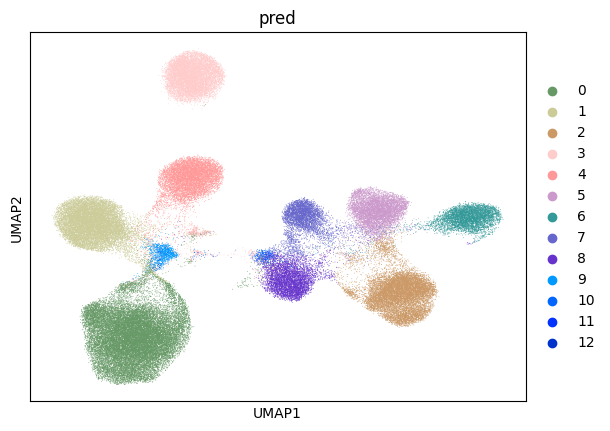

In [3]:
sc.pp.neighbors(y, use_rep='pred_emb',n_neighbors=30)
sc.tl.umap(y)
y.uns['pred_colors'] = [ "#669966" ,"#CCCC99", "#CC9966", "#FFCCCC", "#FF9999", "#CC99CC", '#339999','#6666CC','#6633CC','#0099FF','#0066FF','#0033FF','#0033CC']
sc.pl.umap(y, color=['pred'])

#### dotplot

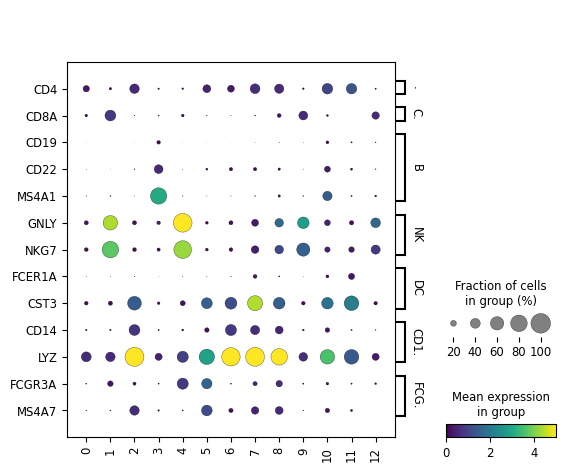

In [4]:
marker_gene_dict = {'CD4+T':['CD4'],'CD8+T':['CD8A'],'B':['CD19','CD22','MS4A1'],'NK':['GNLY','NKG7'],'DC':['FCER1A','CST3'],'CD14 Mono':['CD14','LYZ'],'FCGR3A Mono':['FCGR3A','MS4A7']}
sc.pl.dotplot(y,marker_gene_dict,groupby='pred',color_map='viridis',vmax=5,swap_axes=True)

#### Deg function

In [5]:
def DEG(deg,NUM):
    NUM=NUM
    t12 = deg[[NUM+'_names',NUM+'_pvals_adj',NUM+'_logfoldchanges',NUM+'_pts']]
    t12 = t12[t12[NUM+'_logfoldchanges']>0.25]
    t12 = t12[t12[NUM+'_pvals_adj']<=0.05]
    t12 = t12[t12[NUM+'_pts']>0.1]
    gene0 = list(t12.sort_values(NUM+"_logfoldchanges",ascending=False)[NUM+'_names'])[0:10]
    return gene0

#### The heatmap of DEGs in CD8 T (1,9,12)

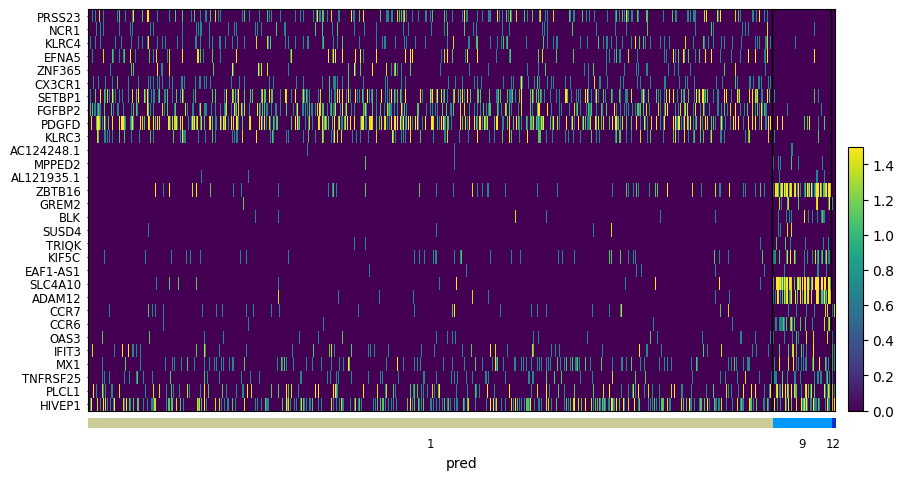

In [6]:
y_cd8=y[[True if i in [1,9,12] else False for i in y.obs['pred'] ]]
y_cd8.obs['pred'] = [str(i) for i in y_cd8.obs['pred']]
sc.pp.log1p(y_cd8)
sc.tl.rank_genes_groups(y_cd8, 'pred', method='wilcoxon',pts =True)
y_cd8.obs['pred'] = [int(i) for i in y_cd8.obs['pred']]
y_cd8.obs['pred'] =y_cd8.obs['pred'].astype('category')

#(y1, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', figsize=(10,7), show=False);
result = y_cd8.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene1=DEG(deg,'1')
gene9=DEG(deg,'9')
gene12=DEG(deg,'12')
sc.pl.heatmap(y_cd8,gene1+gene9+gene12,groupby="pred",vmax=1.5, swap_axes=True)

#### The heatmap of DEGs in DC

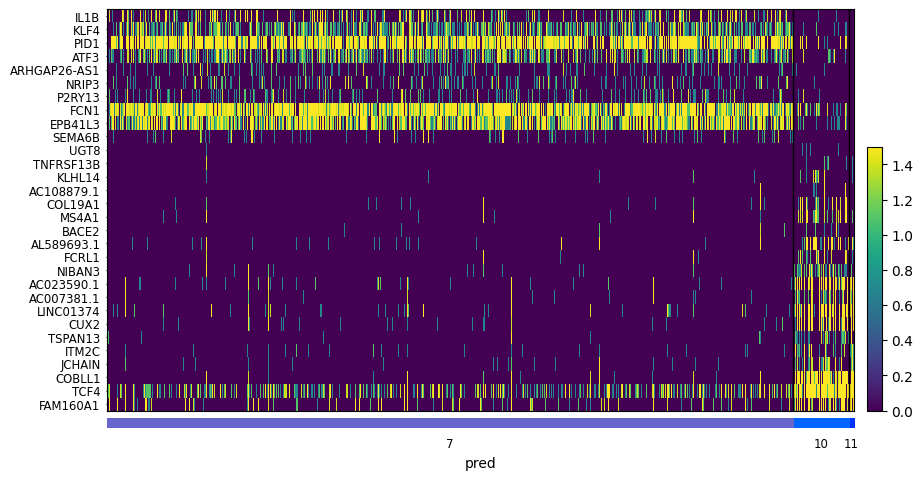

In [7]:
y2=y[[True if i in [7,10,11] else False for i in y.obs['pred'] ]]
y2.obs['pred'] = [str(i) for i in y2.obs['pred']]
sc.pp.log1p(y2)
sc.tl.rank_genes_groups(y2, 'pred', method='wilcoxon',pts =True)
y2.obs['pred'] = [int(i) for i in y2.obs['pred']]
y2.obs['pred'] =y2.obs['pred'].astype('category')

#(y1, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', figsize=(10,7), show=False);
result = y2.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene7=DEG(deg,'7')
gene10=DEG(deg,'10')
gene11=DEG(deg,'11')
sc.pl.heatmap(y2,gene7+gene10+gene11,groupby="pred",vmax=1.5, swap_axes=True)

#### The heatmap of DEGs in all clusters

         Falling back to preprocessing with `sc.pp.pca` and default params.


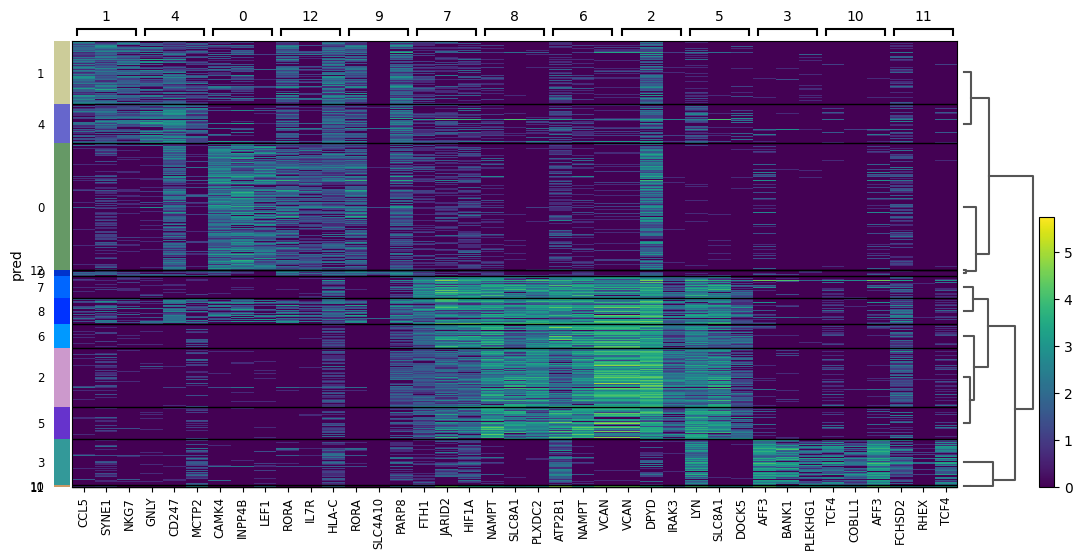

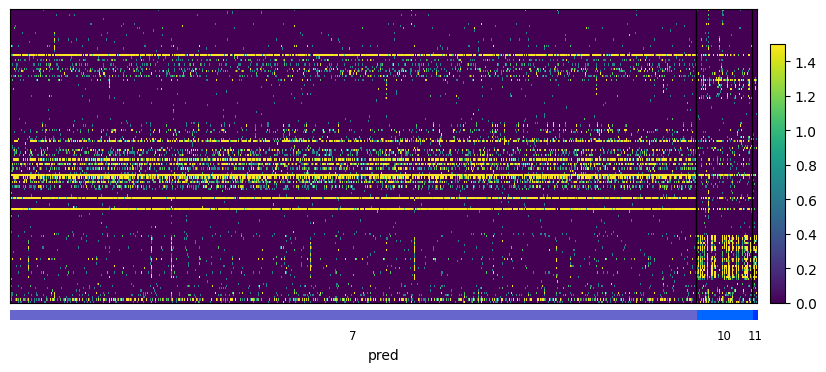

In [8]:
y1=copy.deepcopy(y)
sc.pp.log1p(y1)
sc.tl.rank_genes_groups(y1, 'pred', method='wilcoxon',pts =True)
y1.obs['pred'] = [str(i) for i in y1.obs['pred']]
y1.obs['pred'] =y1.obs['pred'].astype('category')
sc.pl.rank_genes_groups_heatmap(y1, n_genes=3)
result = y1.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene0=DEG(deg,'0')
gene1=DEG(deg,'1')
gene2=DEG(deg,'2')
gene3=DEG(deg,'3')
gene4=DEG(deg,'4')
gene5=DEG(deg,'5')
gene6=DEG(deg,'6')
gene7=DEG(deg,'7')
gene8=DEG(deg,'8')
gene9=DEG(deg,'9')
gene10=DEG(deg,'10')
gene11=DEG(deg,'11')
gene12=DEG(deg,'12')
gene = gene0+gene1+gene2+gene3+gene4+gene5+gene6+gene7+gene8+gene9+gene10+gene11+gene12
sc.pl.heatmap(y2,gene,groupby="pred",vmax=1.5, swap_axes=True)

#### The UMAPs of MAIT markers

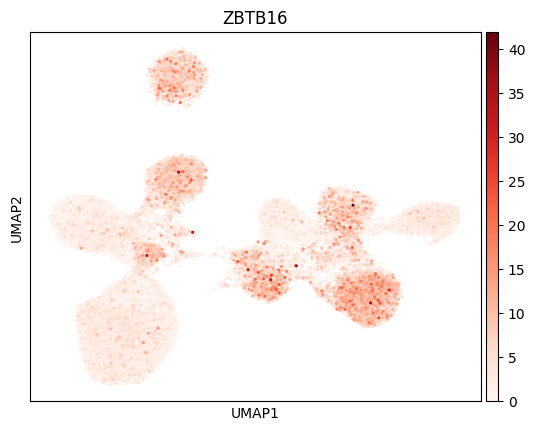

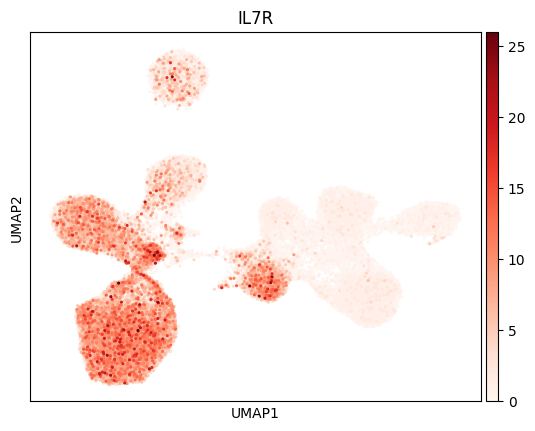

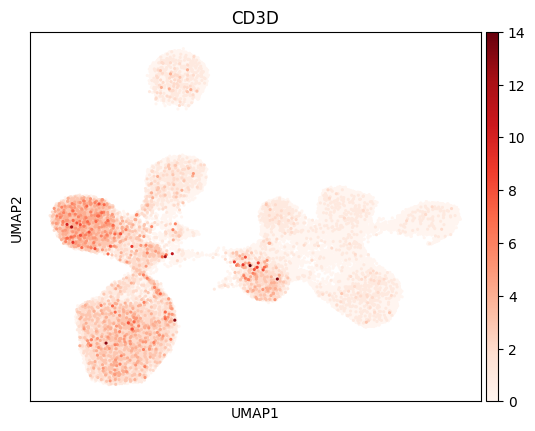

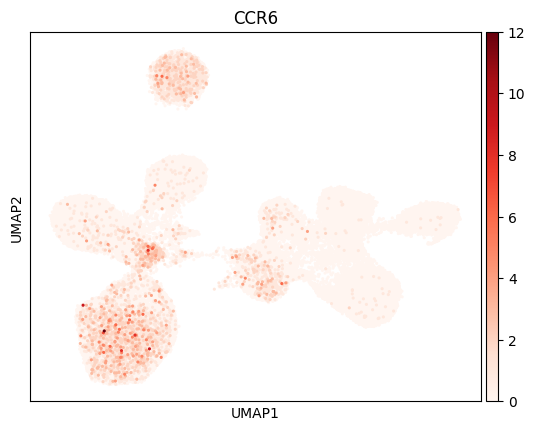

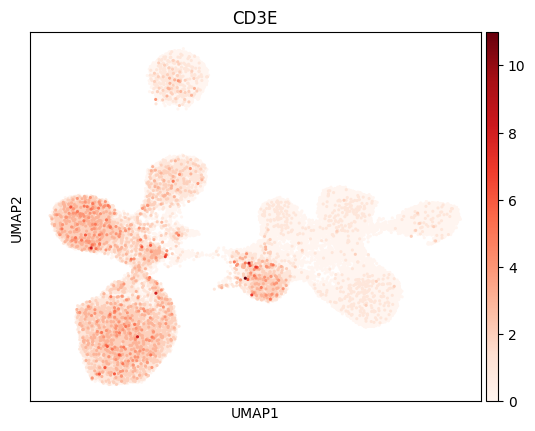

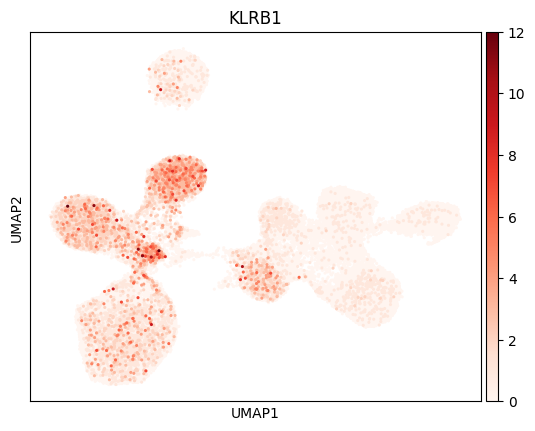

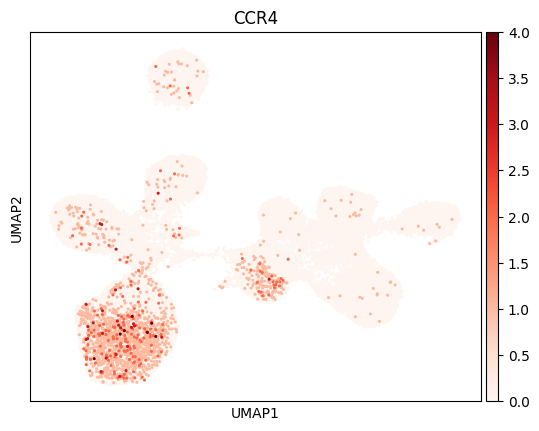

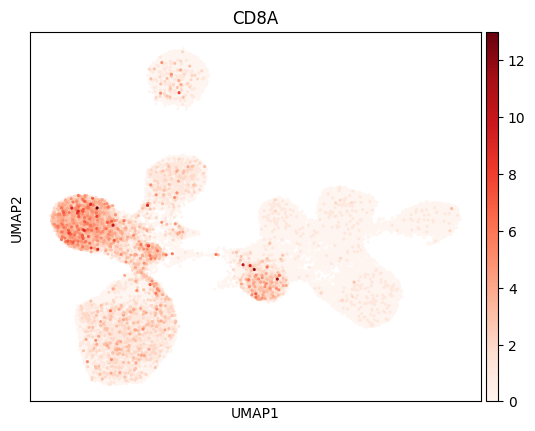

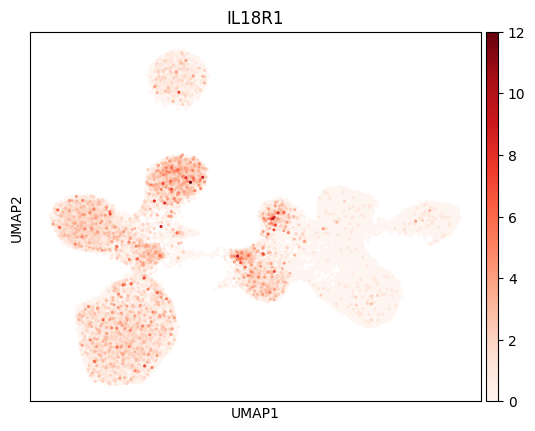

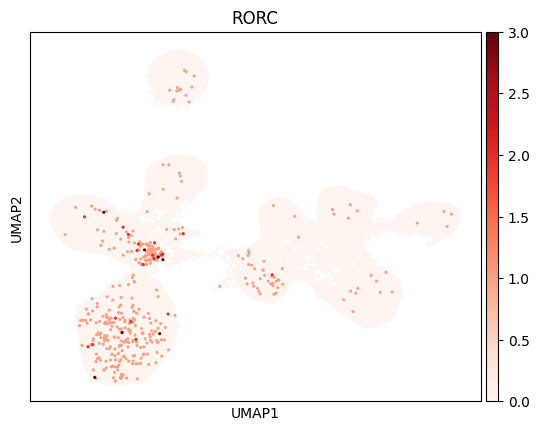

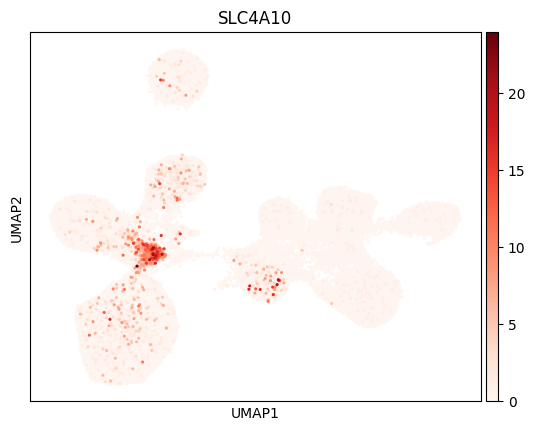

In [9]:
sc.pl.umap(y, color=['ZBTB16'], size=20,cmap='Reds')
sc.pl.umap(y, color=['IL7R'], size=20,cmap='Reds')
sc.pl.umap(y, color=['CD3D'], size=20,cmap='Reds')
sc.pl.umap(y, color=['CCR6'], size=20,cmap='Reds')
sc.pl.umap(y, color=['CD3E'], size=20,cmap='Reds')
sc.pl.umap(y, color=['KLRB1'], size=20,cmap='Reds')
sc.pl.umap(y, color=['CCR4'], size=20,cmap='Reds') #negative
sc.pl.umap(y, color=['CD8A'], size=20,cmap='Reds')
sc.pl.umap(y, color=['IL18R1'], size=20,cmap='Reds')
sc.pl.umap(y, color=['RORC'], size=20,cmap='Reds')
sc.pl.umap(y, color=['SLC4A10'], size=20,cmap='Reds')

#### The marker gene signature of NKT and MAIT 

The calculation of p-value is:  6.29689800271664e-245


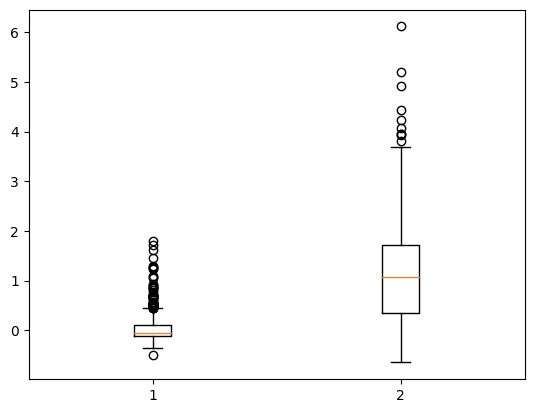

In [12]:
sc.tl.score_genes(y, ['SLAMF1', 'SLAMF6', 'FCGR3A','NCAM1','ITGA2'])
h = y[[True if i in [9,12] else False for i in y.obs['pred']]]
NKT = h.obs['score']
sc.tl.score_genes(y, ['CCR6', 'RORC', 'CD3D','CD8A','KLRB1','CD3E','ZBTB16','IL18R1','IL7R','SLC4A10'])
h = y[[True if i in [9,12] else False for i in y.obs['pred']]]
MAIT = h.obs['score']
plt.boxplot([NKT,MAIT]);

stat,p_value = scipy.stats.mannwhitneyu(NKT,MAIT,alternative='less')
print('The calculation of p-value is: ',str(p_value))

#### MAIT efffect and exhausted

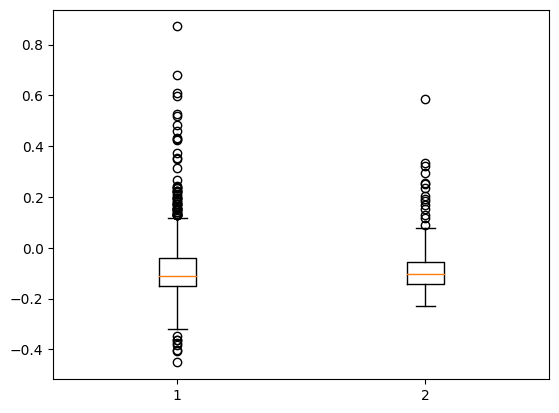

In [13]:
mk = ["low" if i in ["p5", "p6", "p7", "p8"] else i for i in y.obs['batch'] ]
mk = ["high" if i in ["p1", "p2", "p3", "p4"] else i for i in mk ]
mk = ["hd" if i in ["p9", "p10"] else i for i in mk ]
        
group_patient_cluster = [str(mk[i]) + "_" + str(y.obs['pred'][i]) for i in range(len(mk))]
y.obs['group_patient_cluster'] = group_patient_cluster
y.obs['group_patient_cluster'] = y.obs['group_patient_cluster'].astype('category')

#MAIT EFFECT
sc.tl.score_genes(y, ['KLRB1','GZMB','RORC','IL18R1','PRF1','IFNG','TBX21','EOMES','CTLA4'])
#MAIT exhausted
sc.tl.score_genes(y, ['HAVCR2', 'PDCD1', 'LAG3','TIGIT','CD160' ,'CD38','ENTPD1'])
y.obs['IRC'] = mk
y.obs['IRC'] = y.obs['IRC'].astype('category')
h = y[[True if i in [9] else False for i in y.obs['pred'] ]]
hh = h[[True if i in ['high','low'] else False for i in h.obs['IRC'] ]]
plt.boxplot([h[[True if i in ['low'] else False for i in h.obs['IRC']]].obs['score'],h[[True if i in ['high'] else False for i in h.obs['IRC']]].obs['score']]);

#### ZBTB16 related accessibility

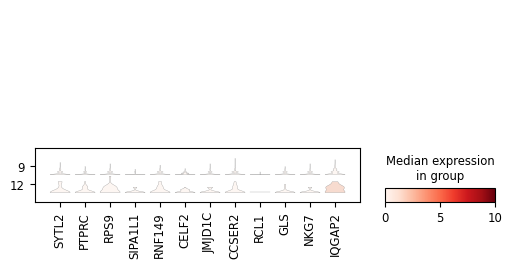

In [14]:
sample='8' 
os.chdir('PBMCs/Sample/P'+sample) # Please switch to the download path of the dataset on your own.
gp = ad.read_mtx('Gene_Peak.mtx')
acc = ad.read_mtx('Peak_Cell.mtx')
genenames = pd.read_csv('Gene_names.tsv',header=None)[0]
peaknames = pd.read_csv('Peak_names.tsv',header=None)[0]
cellnames = pd.read_csv('Cell_names'+sample+'.csv')['x']
gp.obs_names=genenames
gp.var_names=peaknames
acc.obs_names = peaknames
acc.var_names = cellnames

cell = y[[True if i in [9,12] else False for i in y.obs['pred'] ]].obs_names
y[[True if i in [9,12] else False for i in y.obs['pred'] ]]

p=["chr11:85752589-85753493",'chr1:198620935-198621840','chr19:54210656-54211490','chr14:71324553-71325443','chr2:101308300-101309196',"chr10:11162828-11163731","chr10:11178386-11179241","chr10:63268788-63269663",
"chr10:84333777-84334687","chr9:4938812-4939703","chr2:190881662-190882529","chr19:51372411-51373335","chr5:76402535-76403437"]
acc1 = acc.T[cell.intersection(cellnames),:]
acc1 = acc1[:,p]
acc1.obs['pred'] = y[cell.intersection(cellnames)].obs['pred']
peak_gene = ad.AnnData((np.hstack((acc1.X.todense(),np.array(np.mean(acc1[:,["chr10:11162828-11163731","chr10:11178386-11179241"]].X,1))))))
peak_gene.var_names=['SYTL2','PTPRC','RPS9','SIPA1L1','RNF149',"1","2",'JMJD1C','CCSER2','RCL1','GLS','NKG7','IQGAP2','CELF2']

peak_gene.obs_names=cell.intersection(cellnames)
peak_gene.obs['pred'] = y[cell.intersection(cellnames)].obs['pred']
sc.pl.stacked_violin(peak_gene,['SYTL2','PTPRC','RPS9','SIPA1L1','RNF149','CELF2','JMJD1C','CCSER2','RCL1','GLS','NKG7','IQGAP2'], groupby='pred',vmax=10,cmap='Reds')

#### eGRN inference

<Figure size 640x480 with 0 Axes>

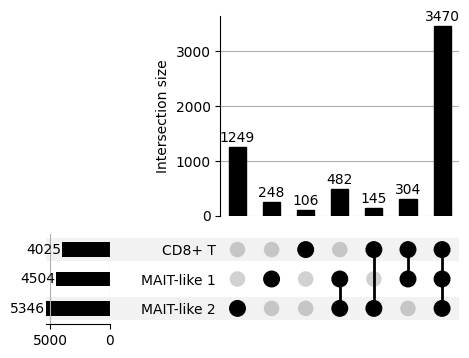

In [15]:
from upsetplot import generate_counts # Please use "pip install upsetplot" to install the package.
from upsetplot import from_contents
from upsetplot import plot
os.chdir('PBMCs/Dataframe') # Please switch to the download path of the dataset on your own.
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("1_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene1 = set(b)

b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("9_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene9 = set(b)

b=list()
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("12_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene12 = set(b)


plt.figure()
contents = {
    "CD8+ T": list(set(gene1)),  
    "MAIT-like 1": list(set(gene9)),      
    "MAIT-like 2": list(set(gene12))
}
plot(from_contents(contents),show_counts='%d');

<Figure size 640x480 with 0 Axes>

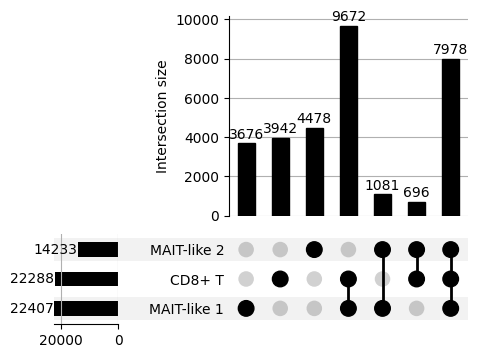

In [16]:
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("1_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak1 = set(b)

b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("9_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak9 = set(b)

b=list()
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("12_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak12 = set(b)


plt.figure()
contents = {
    "CD8+ T": list(set(peak1)),  
    "MAIT-like 1": list(set(peak9)),      
    "MAIT-like 2": list(set(peak12))
}
plot(from_contents(contents),show_counts='%d');